In [1]:
from common import colors

In [2]:
import os
os.chdir(os.path.join('..', '..', '..'))
print(os.getcwd())

/Users/eharkin/Documents/projects/5HTGIF


In [16]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.lines import Line2D
import seaborn as sns
from ezephys import pltools

In [4]:
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'fig1')
plt.style.use(os.path.join('figs', 'scripts', 'writeup', 'publication_figure_style.dms'))

In [5]:
def get_membrane_params_from_all_csv_files(dir_to_search):
    tables = []
    index_files = [
        os.path.join(dirpath, filename)
        for (dirpath, dirs, files) in os.walk(dir_to_search)
        for filename in (dirs + files)
    ]
    index_files = [path for path in index_files if path.endswith('.csv') or path.endswith('CSV')]
    
    tables = [pd.read_csv(path) for path in index_files]
    
    master_table = tables[0].loc[:, ['Cell', 'R', 'C']]
    for table in tables[1:]:
        if 'R' not in table.columns or 'C' not in table.columns:
            print('Table being skipped.')
            continue
    
        master_table = master_table.append(table.loc[:, ['Cell', 'R', 'C']], ignore_index=True)

    master_table.reset_index(inplace=True, drop=True)
    
    return master_table

In [6]:
ser_master_table = get_membrane_params_from_all_csv_files(os.path.join('data', 'raw', '5HT'))
ser_master_table = ser_master_table.groupby('Cell').mean()  # Remove duplicate cells.
ser_master_table['tau'] = ser_master_table['R'] * ser_master_table['C'] * 1e-3
ser_master_table['cell_type'] = 'ser'

Table being skipped.
Table being skipped.


In [7]:
som_master_table = get_membrane_params_from_all_csv_files(os.path.join('data', 'raw', 'GABA'))
som_master_table = som_master_table.groupby('Cell').mean()  # Remove duplicate cells.
som_master_table['tau'] = som_master_table['R'] * som_master_table['C'] * 1e-3
som_master_table['cell_type'] = 'som'

Table being skipped.


In [8]:
pyr_master_table = get_membrane_params_from_all_csv_files(os.path.join('data', 'raw', 'mPFC'))
pyr_master_table = pyr_master_table.groupby('Cell').mean()  # Remove duplicate cells.
pyr_master_table['tau'] = pyr_master_table['R'] * pyr_master_table['C'] * 1e-3
pyr_master_table['cell_type'] = 'pyr'

In [9]:
membrane_params = pd.concat([ser_master_table, som_master_table, pyr_master_table])
membrane_params.groupby('cell_type').mean()

,R,C,tau
cell_type,,,
pyr,187.706667,160.580000,27.447497
ser,1137.836310,65.716429,72.220515
som,1067.392857,43.526786,42.249536


In [10]:
membrane_params.groupby('cell_type').sem()

,R,C,tau
cell_type,,,
pyr,25.963058,9.646133,2.646865
ser,58.346461,1.619425,3.415140
som,110.219590,2.931604,3.738623


In [11]:
membrane_params.groupby('cell_type').std()

,R,C,tau
cell_type,,,
pyr,129.815292,48.230665,13.234324
ser,617.480902,17.138380,36.142443
som,583.227250,15.512590,19.782934


In [24]:
membrane_params.groupby('cell_type').median()

,R,C,tau
cell_type,,,
pyr,135.0,166.0,26.45
ser,1000.0,64.5,67.00
som,1000.0,38.0,40.40


In [25]:
membrane_params.groupby('cell_type').count()

,R,C,tau
cell_type,,,
pyr,25,25,25
ser,112,112,112
som,28,28,28


## Membrane parameter statistics

### Resistance

In [18]:
result = stats.mannwhitneyu(
    membrane_params.groupby('cell_type').get_group('pyr')['R'],
    membrane_params.groupby('cell_type').get_group('som')['R'],
    alternative='two-sided'
)
print(result.pvalue * 3)

5.935848760699349e-09


In [19]:
result = stats.mannwhitneyu(
    membrane_params.groupby('cell_type').get_group('pyr')['R'],
    membrane_params.groupby('cell_type').get_group('ser')['R'],
    alternative='two-sided'
)
print(result.pvalue * 3)

2.8052276258951523e-14


In [20]:
result = stats.mannwhitneyu(
    membrane_params.groupby('cell_type').get_group('ser')['R'],
    membrane_params.groupby('cell_type').get_group('som')['R'],
    alternative='two-sided'
)
print(result.pvalue * 3)

1.6492043765434596


### Time constant

In [21]:
result = stats.mannwhitneyu(
    membrane_params.groupby('cell_type').get_group('pyr')['tau'],
    membrane_params.groupby('cell_type').get_group('som')['tau'],
    alternative='two-sided'
)
print(result.pvalue * 3)

0.015036861436466042


In [22]:
result = stats.mannwhitneyu(
    membrane_params.groupby('cell_type').get_group('pyr')['tau'],
    membrane_params.groupby('cell_type').get_group('ser')['tau'],
    alternative='two-sided'
)
print(result.pvalue * 3)

3.621067680655271e-11


In [23]:
result = stats.mannwhitneyu(
    membrane_params.groupby('cell_type').get_group('ser')['tau'],
    membrane_params.groupby('cell_type').get_group('som')['tau'],
    alternative='two-sided'
)
print(result.pvalue * 3)

8.906878514391146e-06


In [13]:
def counts_to_step(counts, edges):
    """Convert counts and edges from numpy histogram to x and y data for a step histogram plot."""
    counts = np.array([np.concatenate([[0], counts]), np.concatenate([counts, [0]])])
    edges = np.array([edges, edges])
    
    return counts.T.flatten(), edges.T.flatten()

In [14]:
def max_normalized_histogram(x, bins=10, ax=None, vertical=False, **pltargs):
    if ax is None:
        ax = plt.gca()
    
    counts, edges = np.histogram(x, bins)
    y, x = counts_to_step(counts, edges)
    
    if not vertical:
        ax.plot(x, y.astype(np.float64) / y.max(), **pltargs)
    else:
        ax.plot(y.astype(np.float64) / y.max(), x, **pltargs)

/miniconda3/envs/neopozz/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


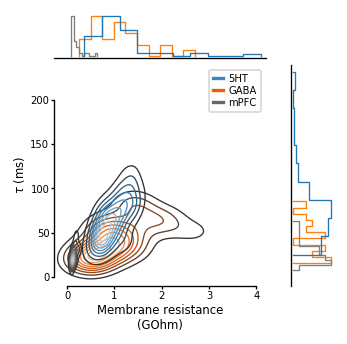

In [15]:
spec = gs.GridSpec(2, 2, height_ratios=[0.2, 1], width_ratios=[1, 0.2], hspace=0.05)

plt.figure(figsize=(3, 3))

plt.subplot(spec[1, 0])
sns.kdeplot(
    membrane_params[membrane_params['cell_type'] == 'som']['R'] * 1e-3, 
    membrane_params[membrane_params['cell_type'] == 'som']['tau'],
    shade_lowest=False,
    cmap='Oranges_d',
    label='GABA'
)
sns.kdeplot(
    membrane_params[membrane_params['cell_type'] == 'pyr']['R'] * 1e-3, 
    membrane_params[membrane_params['cell_type'] == 'pyr']['tau'],
    shade_lowest=False,
    cmap='Greys_d',
    label='mPFC'
)
sns.kdeplot(
    membrane_params[membrane_params['cell_type'] == 'ser']['R'] * 1e-3, 
    membrane_params[membrane_params['cell_type'] == 'ser']['tau'],
    shade_lowest=False,
    cmap='Blues_d',
    label='5HT'
)

custom_lines = [Line2D([0], [0], color=sns.color_palette('Blues_d', 1)[0], lw=2),
                Line2D([0], [0], color=sns.color_palette('Oranges_d', 1)[0], lw=2),
                Line2D([0], [0], color=sns.color_palette('Greys_d', 1)[0], lw=2)]

plt.xlim(-0.270, 4.200)
plt.ylim(-10, 240)
plt.ylabel(r'$\tau$ (ms)')
plt.xlabel('Membrane resistance\n(GOhm)')
plt.legend(custom_lines, ['5HT', 'GABA', 'mPFC'])
pltools.hide_border('tr', trim=True)

plt.subplot(spec[0, 0])
max_normalized_histogram(membrane_params[membrane_params['cell_type'] == 'som']['R'] * 1e-3, color=colors['som'], clip_on=False)
max_normalized_histogram(membrane_params[membrane_params['cell_type'] == 'pyr']['R'] * 1e-3, color=colors['pyr'], clip_on=False)
max_normalized_histogram(membrane_params[membrane_params['cell_type'] == 'ser']['R'] * 1e-3, color=colors['ser'], clip_on=False)
plt.xlim(-0.270, 4.200)
plt.xticks([])
plt.yticks([])
pltools.hide_border('lrt')

plt.subplot(spec[1, 1])
max_normalized_histogram(membrane_params[membrane_params['cell_type'] == 'som']['tau'], color=colors['som'], vertical=True, clip_on=False)
max_normalized_histogram(membrane_params[membrane_params['cell_type'] == 'pyr']['tau'], color=colors['pyr'], vertical=True, clip_on=False)
max_normalized_histogram(membrane_params[membrane_params['cell_type'] == 'ser']['tau'], color=colors['ser'], vertical=True, clip_on=False)
plt.ylim(-10, 240)
plt.xticks([])
plt.yticks([])
pltools.hide_border('trb')

plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'kde_membrane_params_untruncated.png'))

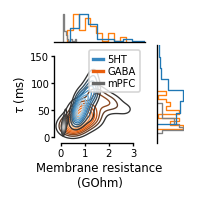

In [16]:
spec = gs.GridSpec(2, 2, height_ratios=[0.3, 1], width_ratios=[1, 0.3], hspace=0.05)

plt.figure(figsize=(1.5, 1.5))

plt.subplot(spec[1, 0])
sns.kdeplot(
    membrane_params[membrane_params['cell_type'] == 'som']['R'] * 1e-3, 
    membrane_params[membrane_params['cell_type'] == 'som']['tau'],
    shade_lowest=False,
    cmap='Oranges_d',
    label='GABA'
)
sns.kdeplot(
    membrane_params[membrane_params['cell_type'] == 'pyr']['R'] * 1e-3, 
    membrane_params[membrane_params['cell_type'] == 'pyr']['tau'],
    shade_lowest=False,
    cmap='Greys_d',
    label='mPFC'
)
sns.kdeplot(
    membrane_params[membrane_params['cell_type'] == 'ser']['R'] * 1e-3, 
    membrane_params[membrane_params['cell_type'] == 'ser']['tau'],
    shade_lowest=False,
    cmap='Blues_d',
    label='5HT'
)

custom_lines = [Line2D([0], [0], color=sns.color_palette('Blues_d', 1)[0], lw=2),
                Line2D([0], [0], color=sns.color_palette('Oranges_d', 1)[0], lw=2),
                Line2D([0], [0], color=sns.color_palette('Greys_d', 1)[0], lw=2)]

plt.xlim(-0.270, 3.500)
plt.xticks([0, 1, 2, 3])
plt.ylim(-10, 170)
plt.ylabel(r'$\tau$ (ms)')
plt.xlabel('Membrane resistance\n(GOhm)')
plt.legend(custom_lines, ['5HT', 'GABA', 'mPFC'])
pltools.hide_border('tr', trim=True)

plt.subplot(spec[0, 0])
max_normalized_histogram(membrane_params[membrane_params['cell_type'] == 'som']['R'] * 1e-3, color=colors['som'])
max_normalized_histogram(membrane_params[membrane_params['cell_type'] == 'pyr']['R'] * 1e-3, color=colors['pyr'])
max_normalized_histogram(membrane_params[membrane_params['cell_type'] == 'ser']['R'] * 1e-3, color=colors['ser'])
plt.xlim(-0.270, 3.500)
plt.xticks([])
plt.yticks([])
pltools.hide_border('lrt')

plt.subplot(spec[1, 1])
max_normalized_histogram(membrane_params[membrane_params['cell_type'] == 'som']['tau'], color=colors['som'], vertical=True)
max_normalized_histogram(membrane_params[membrane_params['cell_type'] == 'pyr']['tau'], color=colors['pyr'], vertical=True)
max_normalized_histogram(membrane_params[membrane_params['cell_type'] == 'ser']['tau'], color=colors['ser'], vertical=True)
plt.ylim(-10, 170)
plt.xticks([])
plt.yticks([])
pltools.hide_border('trb')

plt.subplots_adjust(top=0.97, right=0.97, bottom=0.25, left=0.25)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'kde_membrane_params.png'))
    plt.savefig(os.path.join(IMG_PATH, 'kde_membrane_params.svg'))

In [17]:
membrane_params.loc[
    (membrane_params['cell_type'] == 'ser')
    & (
        (membrane_params['R'] * 1e-3 > 3.5)
        | (membrane_params['tau'] > 170)
    )
]

,R,C,tau,cell_type
Cell,,,,
DRN268,4100.0,33.0,135.3,ser
DRN272,4100.0,26.0,106.6,ser
DRN283,2700.0,86.0,232.2,ser
DRN305,2700.0,65.0,175.5,ser
DRN435,2800.0,78.0,218.4,ser


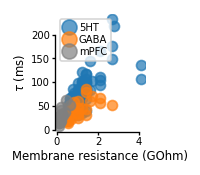

In [18]:
plt.figure(figsize=(1.5, 1.5))

plt.plot(
    membrane_params[membrane_params['cell_type'] == 'ser']['R'] * 1e-3, 
    membrane_params[membrane_params['cell_type'] == 'ser']['tau'],
    'o',
    alpha=0.7,
    color=colors['ser'],
    label='5HT'
)
plt.plot(
    membrane_params[membrane_params['cell_type'] == 'som']['R'] * 1e-3, 
    membrane_params[membrane_params['cell_type'] == 'som']['tau'],
    'o',
    alpha=0.7,
    color=colors['som'],
    label='GABA'
)
plt.plot(
    membrane_params[membrane_params['cell_type'] == 'pyr']['R'] * 1e-3, 
    membrane_params[membrane_params['cell_type'] == 'pyr']['tau'],
    'o',
    alpha=0.7,
    color=colors['pyr'],
    label='mPFC'
)

plt.ylabel(r'$\tau$ (ms)')
plt.xlabel('Membrane resistance (GOhm)')
plt.legend()
pltools.hide_border('tr', trim=True)

plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'raw_data_membrane_params.png'))
    plt.savefig(os.path.join(IMG_PATH, 'raw_data_membrane_params.svg'))

In [19]:
membrane_params

,R,C,tau,cell_type
Cell,,,,
DRN159,707.000000,43.000000,30.401000,ser
DRN160,365.000000,79.000000,28.835000,ser
DRN162,485.000000,57.000000,27.645000,ser
DRN163,1400.000000,61.000000,85.400000,ser
DRN164,919.000000,39.000000,35.841000,ser
DRN165,759.000000,63.000000,47.817000,ser
DRN196,923.000000,74.000000,68.302000,ser
DRN227,1200.000000,86.000000,103.200000,ser
DRN228,791.000000,41.000000,32.431000,ser
